<a href="https://colab.research.google.com/github/katyreena/MAI/blob/main/AI/Homework_2022/LR_5/ML_LW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ТЗ к лабораторной работе №5:
1. реализовать 3 генератора данных на плоскости или в пространстве (равномерное, Гаусс.распр, ... и др)
2. написать реализацию метода Парзена-Розенблатта
3. восстановить плотность в виде картинки
4. для 1 из 3 наборов данных (п.1) применить оптимизацию ширины окна м. LOO
5. для сгенерированных данных с 2-мя и более горбами применить EM-алгоритм из sckit-learn


##Импорт библиотек и вспомогательные функции

In [1]:
import random
import math
import numpy as np
from matplotlib import pyplot as plt
from typing import Mapping
import copy

In [2]:
"""
  Описание: 
    Метод построения графика плотности распределения методом Парзена-Розенблатта.

  Аргументы:
    data_generator: Mapping - набор точек непрерывного распределения.
    title: str - название распределения.
    alpha: float (default: 1.) - параметр рспределения.
    beta: float (default: 1.5) - параметр рспределения.
    h: float (default: 0.3) - параметр метода Парзена-Розенблатта: ширина окна.
    count: int (default: 5000) - количество точек.
"""
def my_plot(data_generator: Mapping, title: str, alpha: float = 1., beta: float = 1.5,
            h: float = 0.3, count: int = 5000):
  data = data_generator(alpha=alpha, beta=beta, count=count)
  x = np.linspace(min(data), max(data), count)
  fig, ax = plt.subplots(figsize=(12, 10))
  ax.plot(x, ParzenRosenblatt(x, h, data))
  ax.set_xlim((min(data), max(data)))
  ax.set_title("Восстановление плотности: " + title + f". Параметры: alpha={alpha},\
  beta={beta}.", fontweight='bold')
  ax.set_xlabel('x')
  ax.set_ylabel('p`(x)')
  plt.show()

##1. Генераторы данных (на плоскости)

###Равномерное распределение

$$R(α, β) \sim F_X(x) ≡ P(X \leqslant x) = \left\{\begin{gathered} 0, \text{ }\text{ }\text{ }\text{ }\text{ }x < α  \\ \frac{x - α}{β - α}, \text{ }\text{ }\text{ }\text{ }\text{ } α \leqslant x \leqslant β \\ 1, \text{ }\text{ }\text{ }\text{ }\text{ } x \geqslant β \\ \end{gathered} \right. $$

In [3]:
"""
  Описание: 
    Метод генерации точеки, подчиняющийся равномерному распределению с указанными параметрами.

  Аргументы: 
    alpha: float (default: 0.) - параметр рспределения: левая граница отрезка.
    beta: float (default: 1.) - параметр рспределения: правая граница отрезка.

  Возврат:
    Значение случайно сгенерированной точки при заданных параметрах равномерного
    распределения (float).
"""
def uniform_distribution(alpha: float = 0., beta: float = 1.) -> float:
  return random.uniform(0, 1) * (beta - alpha) + alpha

"""
  Описание: 
    Метод генерации набора точек, подчиняющихся равномерному распределению с указанными
    параметрами.

  Аргументы: 
    alpha: float (default: 0.) - параметр рспределения: левая граница отрезка.
    beta: float (default: 1.) - параметр рспределения: правая граница отрезка.
    count: int (default: 100) - количество сгенерированных точек.

  Возврат:
    Набор точек (list(float)), сгенерированных при заданных параметрах равномерного
    распределения.
"""
def uniform_generator(alpha: float = 0., beta: float = 1., count: int = 100) -> list:
  return [uniform_distribution(alpha, beta) for i in range(count)]

###Экспоненциальное распределение

$$Exp(α) \sim F_X(x) ≡ P(X \leqslant x) = \left\{\begin{gathered} 1 - e^{-α x}, \text{ }\text{ }\text{ }\text{ }\text{ } x \geqslant 0 \\ \text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }0, \text{ }\text{ }\text{ }\text{ }\text{ } x < 0 \\ \end{gathered} \right. $$

In [4]:
"""
  Описание: 
    Метод генерации точеки, подчиняющийся экспоненциальному распределению с указанными параметрами.

  Аргументы: 
    alpha: float (default: 0.1) - параметр рспределения: коэффициент масштаба.

  Возврат:
    Значение случайно сгенерированной точки при заданных параметрах экспоненциального
    распределения (float).
"""
def exponential_distribution(alpha: float = 0.1) -> float:
  return math.log(1 / (1 - random.uniform(0, 1))) / alpha

"""
  Описание: 
    Метод генерации набора точек, подчиняющихся экспоненциальному распределению с указанными
    параметрами.

  Аргументы: 
    alpha: float (default: 0.) - параметр рспределения: коэффициент масштаба.
    beta: float (default: 1.) - параметр, для обобщения методов (не используется).
    count: int (default: 100) - количество сгенерированных точек.

  Возврат:
    Набор точек (list(float)), сгенерированных при заданных параметрах экспоненциального
    распределения.
"""
def exponential_generator(alpha: float = 0.1, beta: float = 0., count: int = 100) -> list:
  return [exponential_distribution(alpha) for i in range(count)]

###Распределение Вейбулла

$$W(β, α) \sim F_X(x) ≡ P(X \leqslant x) = \left\{\begin{gathered} 1 - e^{{- \left( \frac{x}{α} \right) }^β}, \text{ }\text{ }\text{ }\text{ }\text{ } x \geqslant 0 \\ \text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }\text{ }0, \text{ }\text{ }\text{ }\text{ }\text{ } x < 0 \\ \end{gathered} \right. $$

In [5]:
"""
  Описание: 
    Метод генерации точеки, подчиняющийся распределению Вейбулла с указанными параметрами.

  Аргументы: 
    alpha: float (default: 1.0) - параметр рспределения: коэффициент масштаба.
    beta: float (default: 1.5) - параметр рспределения: коэффициент формы.

  Возврат:
    Значение случайно сгенерированной точки при заданных параметрах распределения
    Вейбулла (float).
"""
def Weibull_distribution(alpha: float = 1.0, k: float = 1.5) -> float:
  return (math.log(1 / (1 - random.uniform(0, 1))) / alpha ** k) ** (1 / k)

"""
  Описание: 
    Метод генерации набора точек, подчиняющихся распределению Вейбулла с указанными
    параметрами.

  Аргументы: 
    alpha: float (default: 0.) - параметр рспределения: коэффициент масштаба.
    beta: float (default: 1.) - параметр рспределения: коэффициент формы.
    count: int (default: 100) - количество сгенерированных точек.

  Возврат:
    Набор точек (list(float)), сгенерированных при заданных параметрах распределения Вейбулла.
"""
def Weibull_generator(alpha: float = 1., beta: float = 1.5, count: int = 100) -> list:
  return [Weibull_distribution(alpha, beta) for i in range(count)]

##2. Метод Парзена-Розенблатта

Оценка плотности Парзена-Розенблатта в одномерном случае имеет вид:

$$\hat{p}_h(x) = \frac{1}{mh} \sum_{i = 1}^{m}{K \left( \frac{x - x^{\left(i\right)}}{h} \right),} $$

где $K(r)$ - ядро (чётная, нормированная функция), $h$ - ширина окна. В качестве ядра ипользуется ядро Коши:

$$ K(x) = \frac{1}{\pi\left( 1 + x^2\right)} .$$

In [6]:
"""
  Описание: 
    Метод возвращающий значение функции ядра Коши при указанных параметрах.

  Аргументы: 
    x: float - параметр функции ядра.

  Возврат:
    Значение функции ядра Коши (float).
"""
def kernel_Cauchy(x: float) -> float:
  return 1 / (math.pi * (1 + x ** 2))

"""
  Описание: 
    Метод возвращающий значение, найденное методом Парзена-Розенблатта для группы точек.

  Аргументы: 
    x: float - параметр функции ядра.
    h: float - параметр метода Парзена-Розенблатта: ширина окна.
    data: list - набор точек.

  Возврат:
    Значение найденное методом Парзена-Розенблатта для группы точек (float).
"""
def ParzenRosenblatt(x: float, h: float, data: list) -> float:
  return sum([kernel_Cauchy((x - i) / h) for i in data]) / (len(data) * h)

##3. Восстановление плотностей



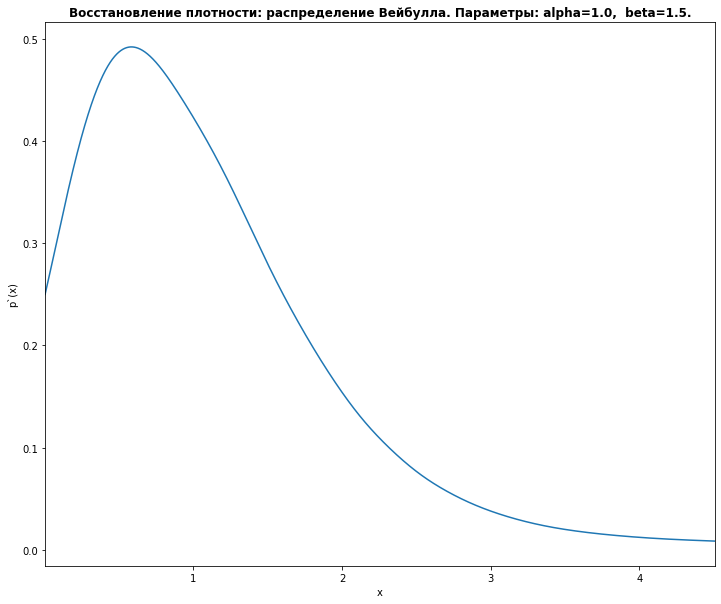

In [7]:
my_plot(Weibull_generator, "распределение Вейбулла")

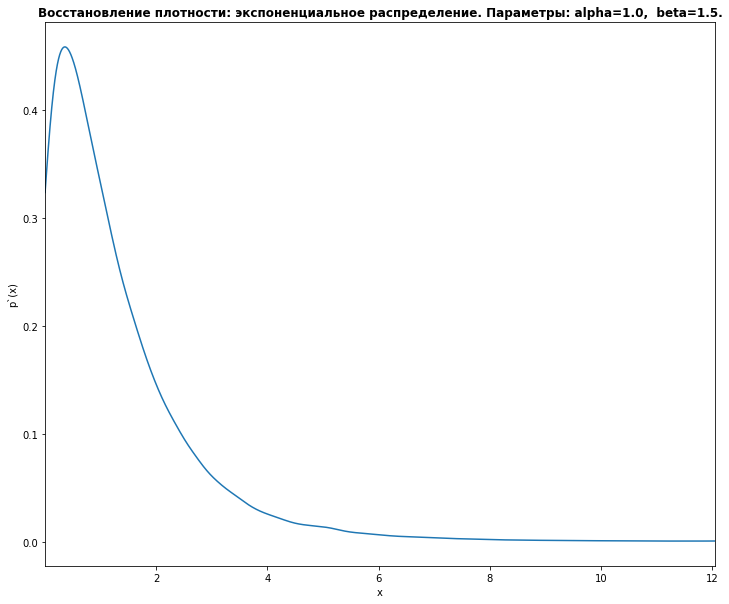

In [8]:
my_plot(exponential_generator, "экспоненциальное распределение")

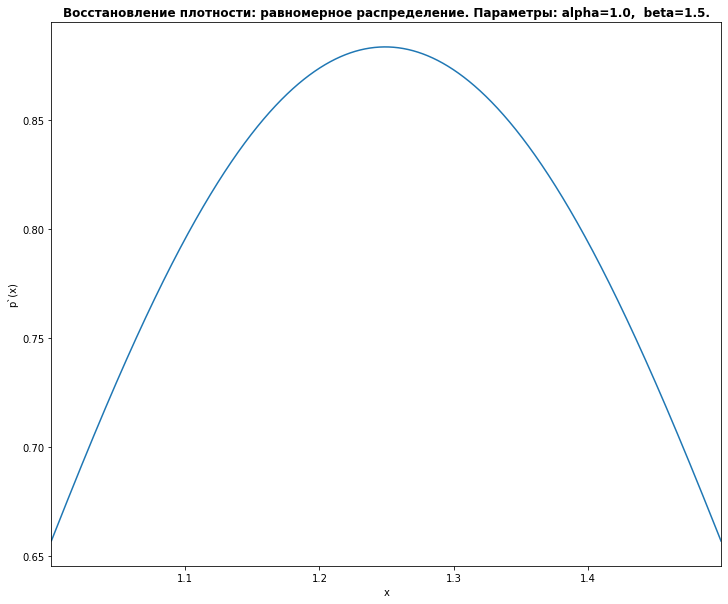

In [9]:
my_plot(uniform_generator, "равномерное распределение")

##4. Метод LOO

$$LOO(h) = - \sum_{i = 1}^{l} {ln \left( \hat{p}_h \left( x_i; \frac{X^l}{x_i}\right) \right)} \longrightarrow min_h$$

In [10]:
"""
  Описание: реализация метода leave one out.

  Аргументы:
    data: list - массив данных.
    h: float - ширина окна.

  Возврат: значение оптимизированной ширины окна (float).
"""
def LOO(data: list, h: float) -> float:
    return -sum([math.log(ParzenRosenblatt(data[i], h, data[:i] + data[i+1:])) for i in range(len(data))])

print(f"Значение по м. LOO для h = 0.1: {LOO(Weibull_generator(count=500), 0.1)}.")

Значение по м. LOO для h = 0.1: 418.08672252988833.


##5. EM-алгоритм

In [24]:
def TwoWeibull(alpha_first: float = 1.0, k_first: float = 1.5, alpha_second: float = 1.5,
               k_second: float = 1.0) -> np.ndarray:
    res = []
    for i in range(500):
        res.append(Weibull_distribution(alpha_first, k_first))
        res.append(Weibull_distribution(alpha_second, k_second))
    return np.array(res) 

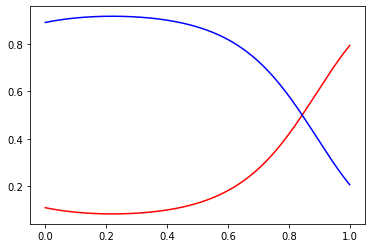

In [30]:
from sklearn.mixture import GaussianMixture

twoWeibull = TwoWeibull().reshape(-1, 1)
gm = GaussianMixture(n_components=2, covariance_type='full', init_params='random',
                     random_state=0).fit(twoWeibull)

x = np.linspace(0, 1, 1000)
y_red = gm.predict_proba(np.array(x).reshape(-1, 1))[:,0]
y_blue = gm.predict_proba(np.array(x).reshape(-1, 1))[:,1]
plt.plot(x, y_red, color = 'red')
plt.plot(x, y_blue, color = 'blue') 

plt.show()